In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, RandomizedSearchCV
import pickle

In [ ]:
df = pd.read_parquet('/content/sample_data/est_hourly.paruqet')
#df=pd.read_csv('/content/sample_data/PJME_hourly.csv')
df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [ ]:
df['PJM_Load']

,PJM_Load
Datetime,
1998-12-31 01:00:00+00:00,29309.0
1998-12-31 02:00:00+00:00,28236.0
1998-12-31 03:00:00+00:00,27692.0
1998-12-31 04:00:00+00:00,27596.0
1998-12-31 05:00:00+00:00,27888.0
...,...
2018-01-01 20:00:00+00:00,NaN
2018-01-01 21:00:00+00:00,NaN
2018-01-01 22:00:00+00:00,NaN


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [ ]:
df.isnull().sum()

,0
AEP,56989
COMED,111765
DAYTON,56987
DEOK,120523
DOM,62073
DUQ,59194
EKPC,132928
FE,115388
NI,119812
PJME,32896


In [ ]:
# bring Datetime index to column
df.reset_index(inplace=True)
df.dtypes

,0
Datetime,"datetime64[ms, UTC]"
AEP,float64
COMED,float64
DAYTON,float64
DEOK,float64
DOM,float64
DUQ,float64
EKPC,float64
FE,float64
NI,float64


In [ ]:
# Looking at distribution of load by region
#df.plot.hist(figsize=(15, 5), bins=200, title='Distribution of Load by Region')
#plt.show()

In [ ]:
regions = ["AEP", "COMED", "DAYTON", "DEOK", "DOM", "DUQ", "EKPC", "FE", "NI", "PJME", "PJMW"]

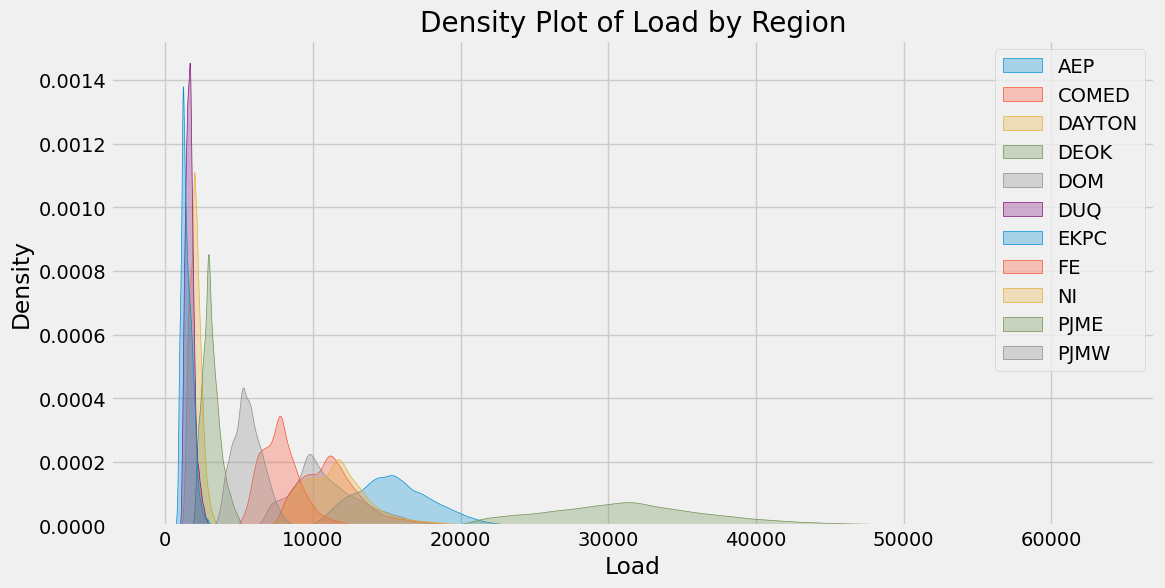

In [ ]:

#KDE plot - smoothed distr.curve
plt.figure(figsize=(12, 6))
for region in regions:
    sns.kdeplot(df[region].dropna(), label=region, fill=True, alpha=0.3)
plt.legend()
plt.title("Density Plot of Load by Region")
plt.xlabel("Load")
plt.show()

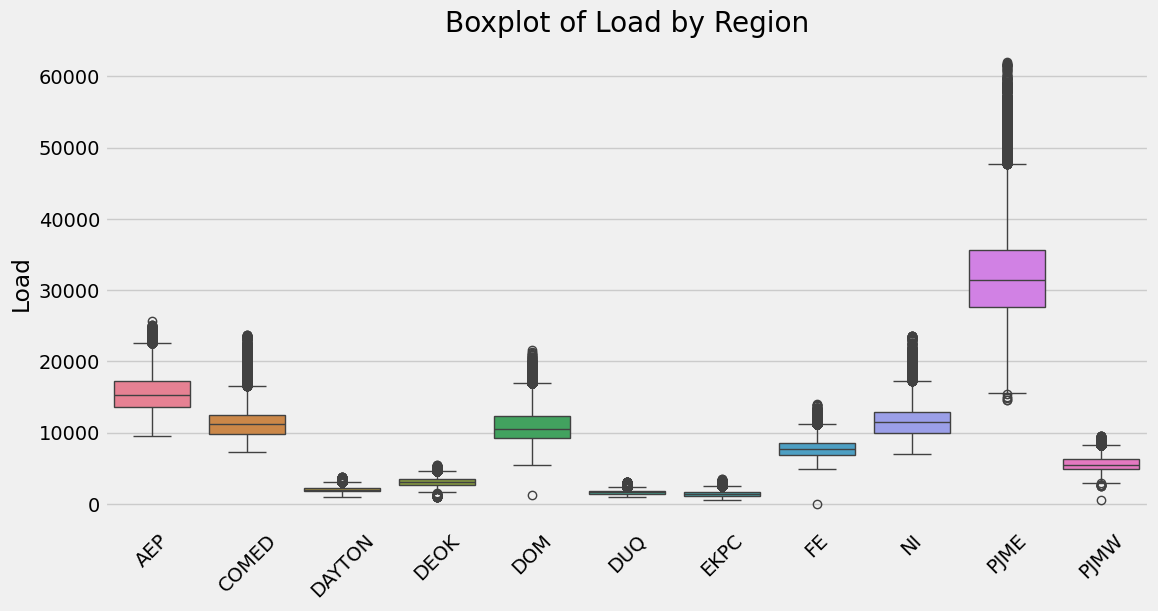

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[regions])
plt.xticks(rotation=45)
plt.title("Boxplot of Load by Region")
plt.ylabel("Load")
plt.show()

In [ ]:
# set datetime as index
df.set_index('Datetime', inplace=True)

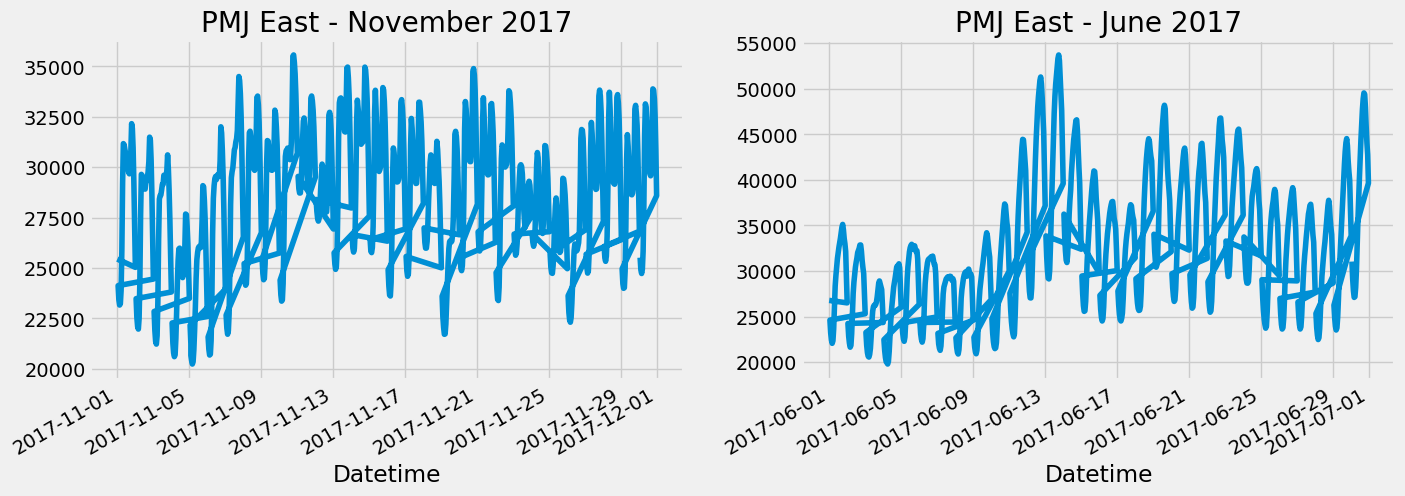

In [ ]:
#df.index = pd.to_datetime(df.index)
#df['Date'] = pd.to_datetime(df['Datetime'], errors='coerce')  # Will convert invalid dates to NaT
#df.dropna(subset=['Date'], inplace=True)  # Drop rows where date couldn’t be parsed
#df.set_index('Date', inplace=True)
#Summer Demand vs Winter Demand
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the first line on the first axis
df['PJME'].loc[(df['PJME'].index >= '2017-11-01') & (df['PJME'].index < '2017-12-01')].plot(ax=ax1, title='PMJ East - November 2017')

# plot the second line on the second axis
df['PJME'].loc[(df['PJME'].index >= '2017-06-01') & (df['PJME'].index < '2017-07-01')].plot(ax=ax2, title='PMJ East - June 2017')

# show the plot
plt.show()

In [ ]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
# Apply feature creation
df = create_features(df)
df.head()



,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,,,,,,,,,
1998-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0,1,3,4,12,1998,365,31,53
1998-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0,2,3,4,12,1998,365,31,53
1998-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0,3,3,4,12,1998,365,31,53
1998-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0,4,3,4,12,1998,365,31,53
1998-12-31 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0,5,3,4,12,1998,365,31,53


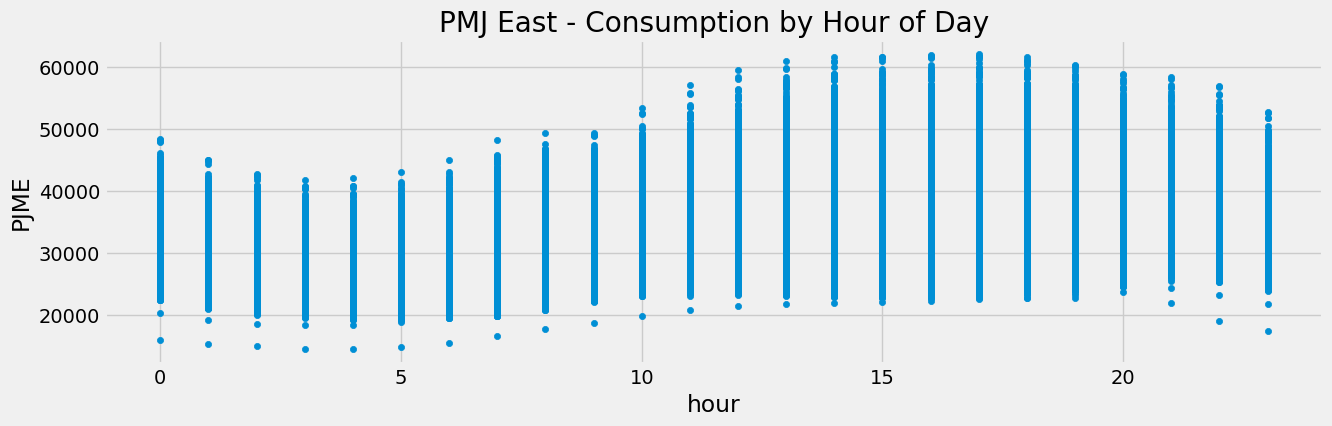

In [ ]:
_ = df[['PJME','hour']].plot(x='hour',
                                     y='PJME',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='PMJ East - Consumption by Hour of Day')

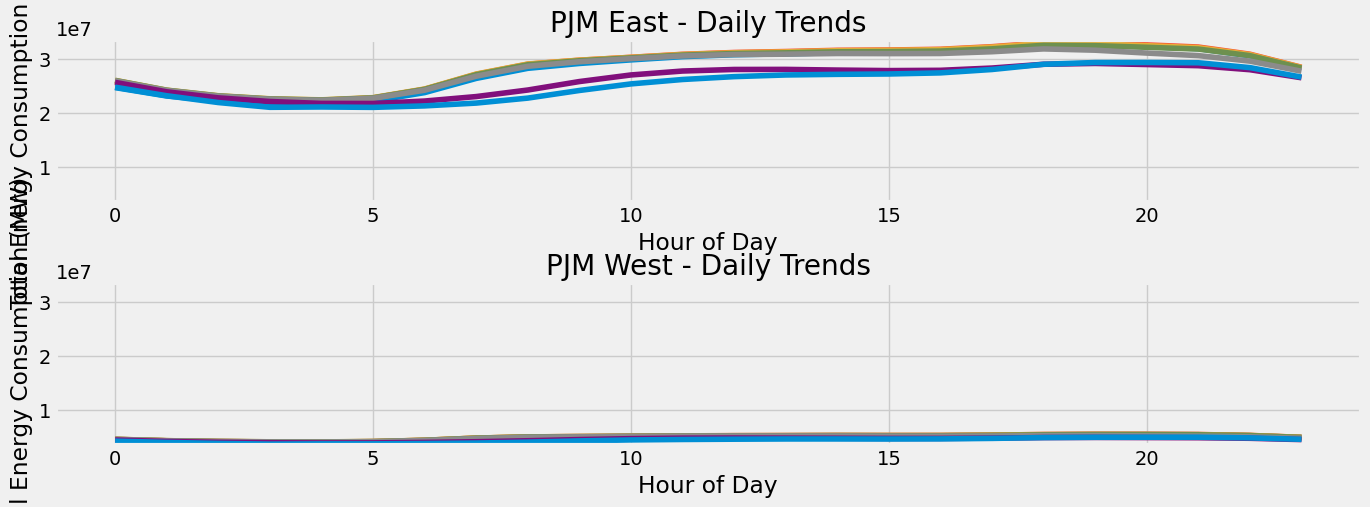

In [ ]:
# show PJM East and PMJ West daily trends on the same fig

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

df.pivot_table(index=df['hour'],
               columns='dayofweek',
               values='PJME',
               aggfunc='sum').plot(ax=ax1,
                                   title='PJM East - Daily Trends',
                                   legend=False)

df.pivot_table(index=df['hour'],
               columns='dayofweek',
               values='PJMW',
               aggfunc='sum').plot(ax=ax2,
                                   title='PJM West - Daily Trends',
                                   legend=False)

# set y limits to be the same for both plots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

ax1.set_ylabel('Total Energy Consumption (MW)')
ax2.set_ylabel('Total Energy Consumption (MW)')
ax1.set_xlabel('Hour of Day')
ax2.set_xlabel('Hour of Day')

fig.subplots_adjust(hspace=0.5)

plt.show()

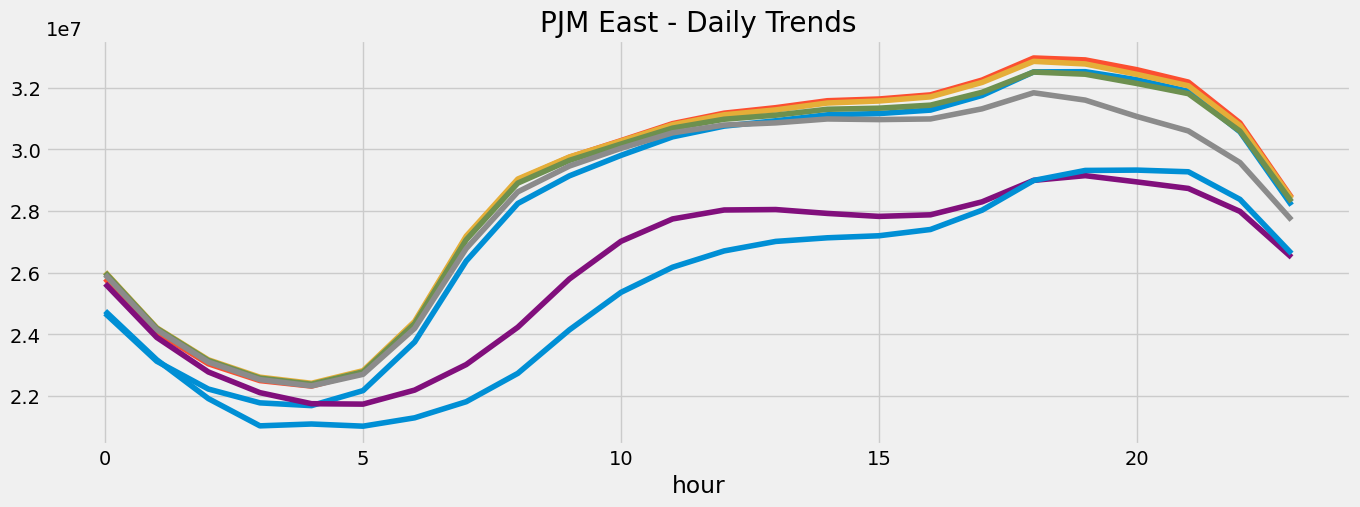

In [ ]:
# Looking at just PJM East daily trends
df.pivot_table(index=df['hour'],
               columns='dayofweek',
               values='PJME',
               aggfunc='sum').plot(figsize=(15, 5),
                            title='PJM East - Daily Trends',
                            legend=False)

plt.show()


In [ ]:
# xgBoost model with a train/test split and time series cross-validation

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'dayofyear','year']
TARGET = 'PJME'

# Define the features and target
X = df[FEATURES]
y = df[TARGET]

# Replace NaN and infinite values in features with appropriate statistics (e.g., mean or median)
#X = X.fillna(X.mean())
#for column in X.columns:  # Loop through all columns of X
    #X[column] = X[column].replace([np.inf, -np.inf], X[column].mean()) # Replace inf in each col with its mean

#Before splitting the data, handle invalid values in 'y'
y = y.fillna(y.mean()) # Replace NaN with the mean
y = y.replace([np.inf, -np.inf], y.mean()) #Replace inf with mean

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost model
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    reg.fit(X_train_cv, y_train_cv,
        eval_set=[(X_test_cv, y_test_cv)], #provide validation set
        verbose=True)

    # Make predictions
    y_pred = reg.predict(X_test_cv)
    # Calculate the mean squared error
    mse = mean_squared_error(y_test_cv, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error: {rmse}")

    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test_cv, y_pred)
    print(f"Mean Absolute Error: {mae}")

# Use the holdout set to assess final performance of the model
y_pred_holdout = reg.predict(X_test)
mse_holdout = mean_squared_error(y_test, y_pred_holdout)
print(f"Holdout Mean Squared Error: {mse_holdout}")

# Calculate the root mean squared error of the holdout set
rmse_holdout = np.sqrt(mse_holdout)
print(f"Root Mean Squared Error: {rmse_holdout}")

# Calculate the mean absolute error of the holdout set
mae_holdout = mean_absolute_error(y_test, y_pred_holdout)
print(f"Mean Absolute Error: {mae_holdout}")


Streaming output truncated to the last 5000 lines.
[18]	validation_0-rmse:5155.81754
[19]	validation_0-rmse:5155.81754
[20]	validation_0-rmse:5155.81754
[21]	validation_0-rmse:5155.81754
[22]	validation_0-rmse:5155.81754
[23]	validation_0-rmse:5155.81754
[24]	validation_0-rmse:5155.81754
[25]	validation_0-rmse:5155.81754
[26]	validation_0-rmse:5155.81754
[27]	validation_0-rmse:5155.81754
[28]	validation_0-rmse:5155.81754
[29]	validation_0-rmse:5155.81754
[30]	validation_0-rmse:5155.81754
[31]	validation_0-rmse:5155.81754
[32]	validation_0-rmse:5155.81754
[33]	validation_0-rmse:5155.81754
[34]	validation_0-rmse:5155.81754
[35]	validation_0-rmse:5155.81754
[36]	validation_0-rmse:5155.81754
[37]	validation_0-rmse:5155.81754
[38]	validation_0-rmse:5155.81754
[39]	validation_0-rmse:5155.81754
[40]	validation_0-rmse:5155.81754
[41]	validation_0-rmse:5155.81754
[42]	validation_0-rmse:5155.81754
[43]	validation_0-rmse:5155.81754
[44]	validation_0-rmse:5155.81754
[45]	validation_0-rmse:5155.817

In [ ]:
# Make predictions on the test set
y_pred = reg.predict(X_test)

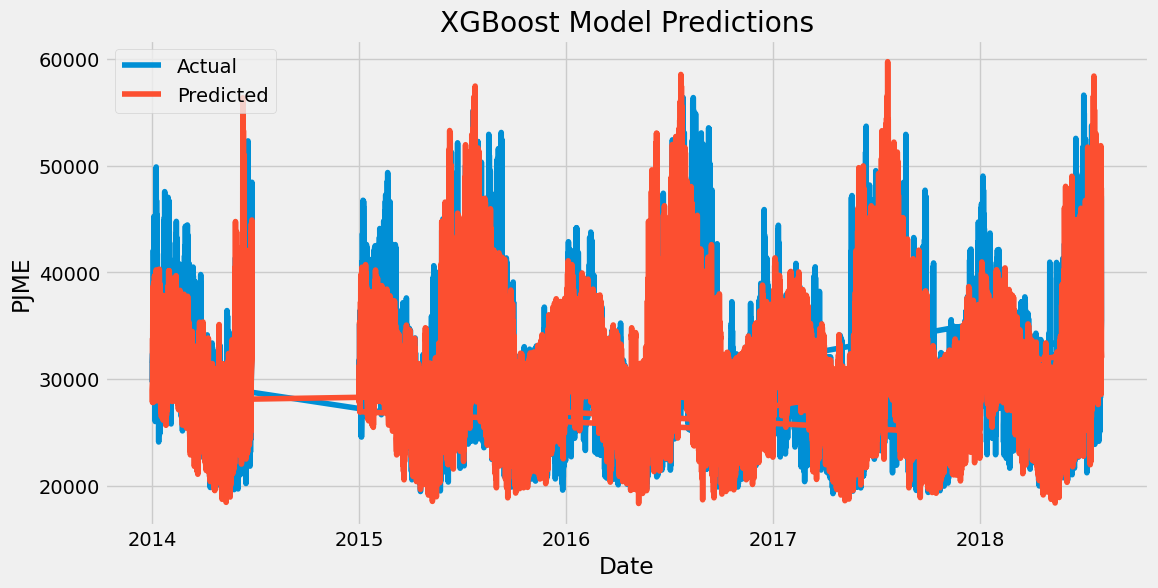

In [ ]:
# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions')
plt.legend()
plt.show()

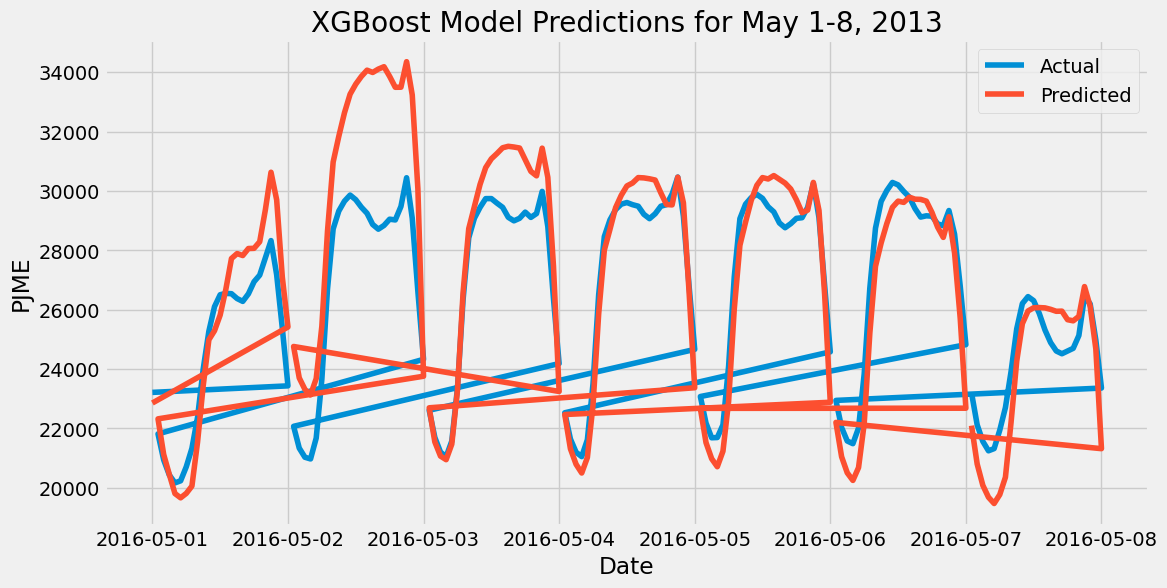

In [ ]:
# Looking at one week of data
# Looking at one week of data
# Select the data for one week in May 2016
start_date = '2016-05-01'
end_date = '2016-05-08'
mask = (y_test.index >= start_date) & (y_test.index <= end_date)
y_test_week = y_test.loc[mask]
y_pred_week = pd.Series(y_pred, index=y_test.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week.index, y_test_week.values, label='Actual')
plt.plot(y_test_week.index, y_pred_week, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions for May 1-8, 2013')
plt.legend()
plt.show()

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index =reg.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

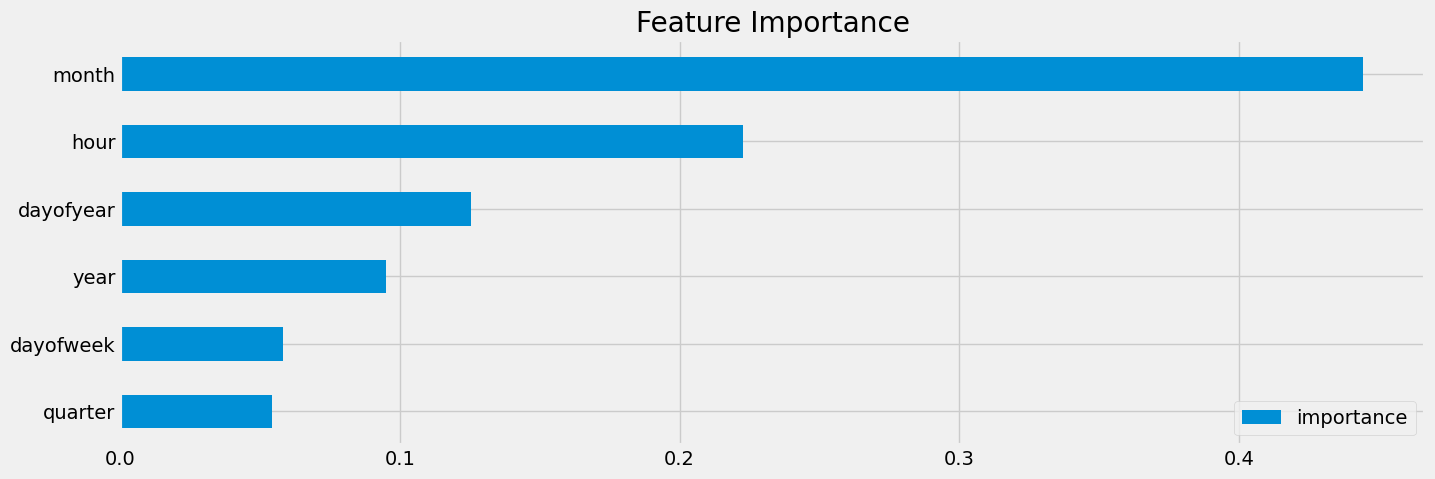

In [ ]:
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

Cross-validation RMSE: 4404.580295669391 ± 999.5935779982946


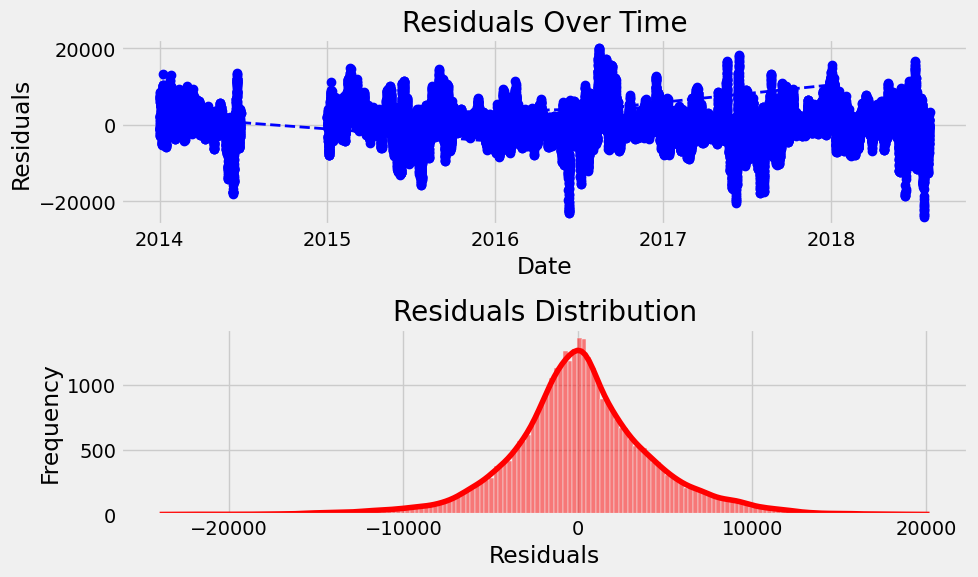

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))

# Plot residuals over time
plt.subplot(2, 1, 1)
plt.plot(y_test.index, residuals, color='blue', marker='o', linestyle='dashed', linewidth=2)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot residuals distribution
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, color='red')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#Add lag features
# Creating multiple lag features
df_2=df.copy()
df_2.head()
df_2['lag_1'] = df_2['PJME'].shift(1)
df_2['lag_2'] = df_2['PJME'].shift(2)
df_2['lag_3'] = df_2['PJME'].shift(3)
df_2['lag_24'] = df_2['PJME'].shift(24)
df_2['lag_168'] = df_2['PJME'].shift(168)
df_2.head()

#lags = [1, 2, 3, 24, 168]  # Define desired lags
#for lag in lags:
    #df_2[f'lag_{lag}'] = df['value'].shift(lag)




,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,...,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,lag_3,lag_24,lag_168
Datetime,,,,,,,,,,,,,,,,,,,,,
1998-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1998,365,31,53,NaN,NaN,NaN,NaN,NaN
1998-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1998,365,31,53,NaN,NaN,NaN,NaN,NaN
1998-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1998,365,31,53,NaN,NaN,NaN,NaN,NaN
1998-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1998,365,31,53,NaN,NaN,NaN,NaN,NaN
1998-12-31 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1998,365,31,53,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Regression using Lags

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1', 'lag_2','lag_3', 'lag_24', 'lag_168']
TARGET = ['PJME']

# Assuming your data is in a DataFrame called pjm3_df3
X2 = df_2[FEATURES]
y2 = df_2[TARGET]

# Split the data into training and testing sets
X_train_all2, X_test_all2, y_train_all2, y_test_all2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)


# Drop rows with NaN values in either features or target after creating lag features and splitting data
X_train_all2 = X_train_all2.dropna()
y_train_all2 = y_train_all2.dropna()
# Align X_train_all2 and y_train_all2 indices after dropping NaN values
y_train_all2 = y_train_all2.loc[X_train_all2.index]


# Create a TimeSeriesSplit object
tscv2 = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost model
reg2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index2, test_index2 in tscv.split(X_train_all2):
    X_train2, X_test2 = X_train_all2.iloc[train_index2], X_train_all2.iloc[test_index2]
    y_train2, y_test2 = y_train_all2.iloc[train_index2], y_train_all2.iloc[test_index2]

    reg2.fit(X_train2, y_train2,
        eval_set=[(X_test2, y_test2)], #provide validation set
        verbose=True)

    y_pred_cv2 = reg2.predict(X_test2)
    mse_cv2 = mean_squared_error(y_test2, y_pred_cv2)
    print(f"Mean Squared Error (CV): {mse_cv2}")

    # Calculate the root mean squared error
    rmse3 = np.sqrt(mse_cv2)
    print(f"Root Mean Squared Error: {rmse3}")

    # Calculate the mean absolute error
    mae2 = mean_absolute_error(y_test2, y_pred_cv2)
    print(f"Mean Absolute Error: {mae2}")

# Use the holdout set to assess final performance of the model
y_pred_holdout2 = reg2.predict(X_test_all2)  # Use X_test_all3 instead of X_test3
mse_holdout2 = mean_squared_error(y_test_all2, y_pred_holdout2)  # Use y_test_all3 instead of y_test3
print(f"Holdout Mean Squared Error: {mse_holdout2}")

# Calculate the root mean squared error of the holdout set
rmse_holdout2 = np.sqrt(mse_holdout2)
print(f"Root Mean Squared Error: {rmse_holdout2}")

# Calculate the mean absolute error of the holdout set
mae_holdout2 = mean_absolute_error(y_test_all2, y_pred_holdout2)  # Use y_test_all3 instead of y_test3
print(f"Mean Absolute Error: {mae_holdout2}")

Streaming output truncated to the last 5000 lines.
[18]	validation_0-rmse:1244.11499
[19]	validation_0-rmse:1174.59101
[20]	validation_0-rmse:1116.17030
[21]	validation_0-rmse:1062.09414
[22]	validation_0-rmse:1016.60240
[23]	validation_0-rmse:976.77215
[24]	validation_0-rmse:940.98990
[25]	validation_0-rmse:908.84119
[26]	validation_0-rmse:880.74102
[27]	validation_0-rmse:856.31401
[28]	validation_0-rmse:837.86145
[29]	validation_0-rmse:819.51519
[30]	validation_0-rmse:803.11318
[31]	validation_0-rmse:789.17630
[32]	validation_0-rmse:779.27360
[33]	validation_0-rmse:769.57832
[34]	validation_0-rmse:761.12905
[35]	validation_0-rmse:752.47435
[36]	validation_0-rmse:745.83656
[37]	validation_0-rmse:738.27689
[38]	validation_0-rmse:732.55580
[39]	validation_0-rmse:727.30484
[40]	validation_0-rmse:721.03610
[41]	validation_0-rmse:716.95405
[42]	validation_0-rmse:710.63577
[43]	validation_0-rmse:705.97394
[44]	validation_0-rmse:702.79487
[45]	validation_0-rmse:697.34619
[46]	validation_0-rm

In [ ]:
# Make predictions on the test set
y_pred2 = reg2.predict(X_test2)

In [ ]:
fi_lags = pd.DataFrame(data=reg2.feature_importances_,
                index =reg2.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

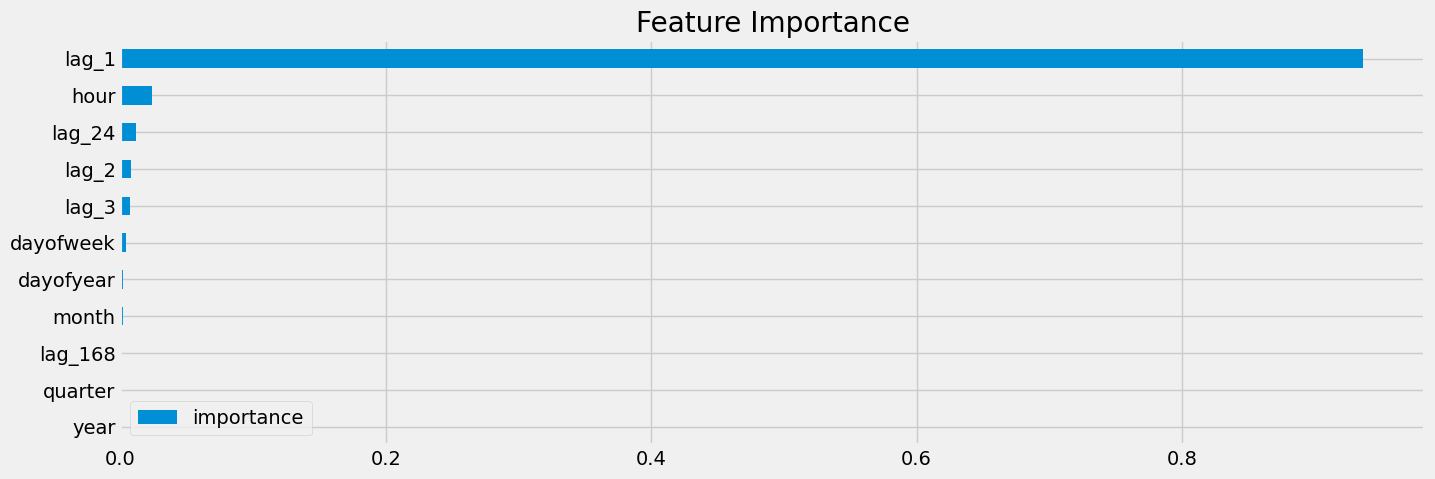

In [ ]:
fi_lags.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

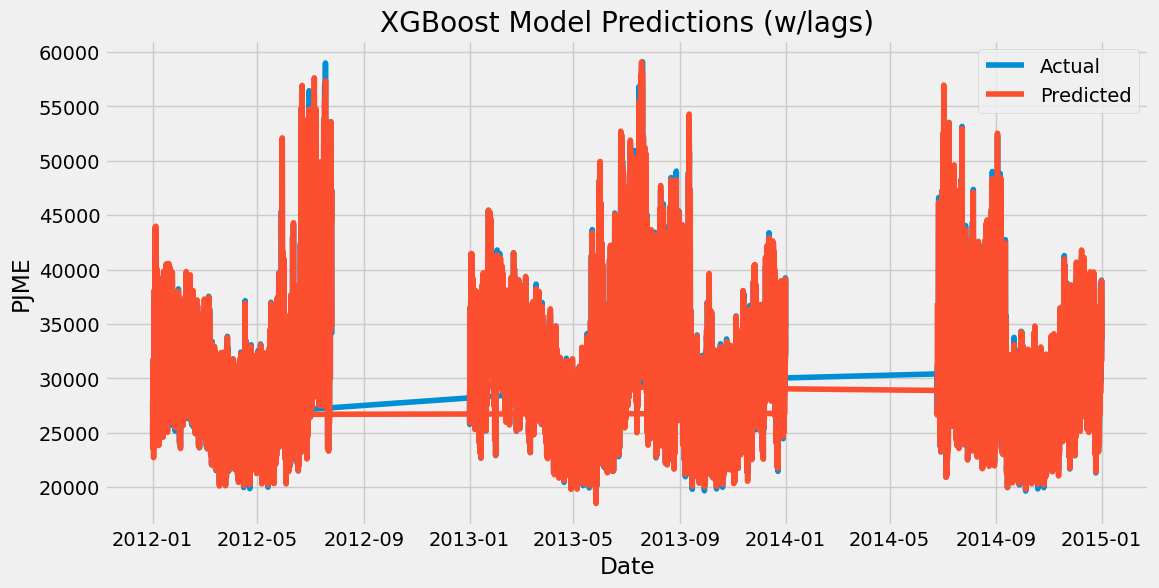

In [ ]:
# Plot the actual values and predicted values for the third model
plt.figure(figsize=(12, 6))
plt.plot(y_test2.index, y_test2.values, label='Actual')
plt.plot(y_test2.index, y_pred2, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions (w/lags)')
plt.legend()
plt.show()

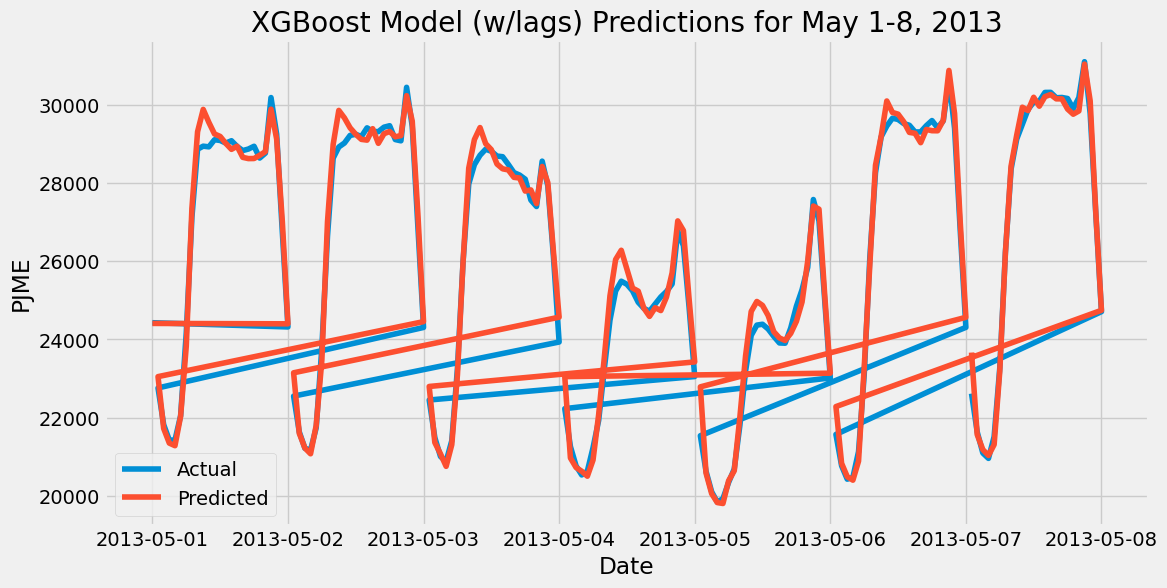

In [ ]:
# Looking at one week of data
# Select the data for one week in May 2013
start_date = '2013-05-01'
end_date = '2013-05-08'
mask = (y_test2.index >= start_date) & (y_test2.index <= end_date)
y_test_week2 = y_test2.loc[mask]
y_pred_week2 = pd.Series(y_pred2, index=y_test2.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week2.index, y_test_week2.values, label='Actual')
plt.plot(y_test_week2.index, y_pred_week2, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model (w/lags) Predictions for May 1-8, 2013')
plt.legend()
plt.show()

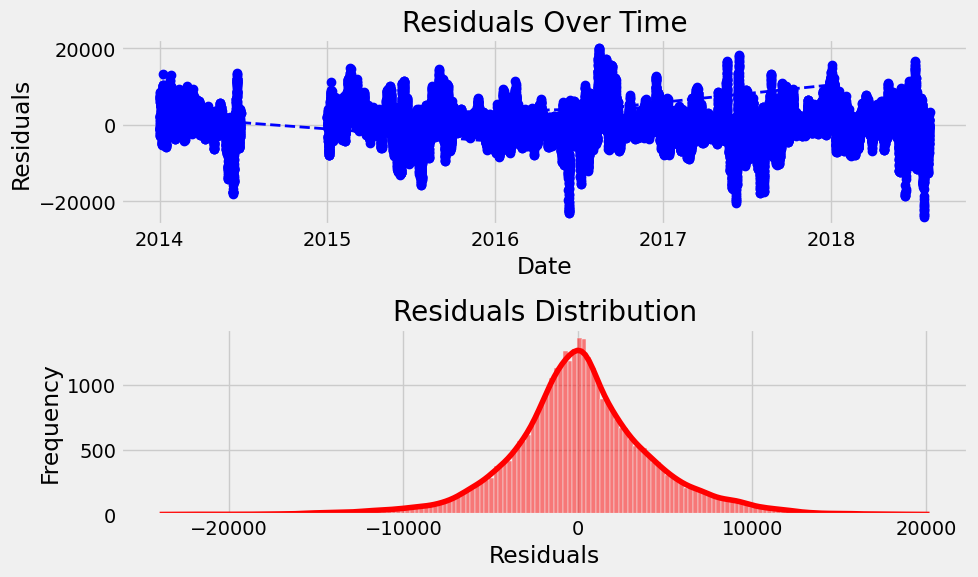

In [ ]:
# Plot residuals
plt.figure(figsize=(10, 6))

# Plot residuals over time
plt.subplot(2, 1, 1)
plt.plot(y_test.index, residuals, color='blue', marker='o', linestyle='dashed', linewidth=2)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot residuals distribution
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, color='red')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#Add rolling
df_3=df_2.copy()
df_3['rolling_mean_14'] = df_3[TARGET].shift(1).rolling(window=14).mean()
df_3['rolling_mean_30'] = df_3[TARGET].shift(1).rolling(window=30).mean()

df_3.head()



,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,...,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_14,rolling_mean_30
Datetime,,,,,,,,,,,,,,,,,,,,,
1998-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,31,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,31,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,31,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,31,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-31 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,31,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Regression using rolling

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1', 'lag_2','lag_3', 'lag_24', 'lag_168', 'rolling_mean_14', 'rolling_mean_30']
TARGET = ['PJME']

# Assuming your data is in a DataFrame called pjm3_df3
X3 = df_3[FEATURES]
y3 = df_3[TARGET]

# Split the data into training and testing sets
X_train_all3, X_test_all3, y_train_all3, y_test_all3 = train_test_split(X3, y3, test_size=0.2, shuffle=False)


# Drop rows with NaN values in either features or target after creating lag features and splitting data
X_train_all3 = X_train_all3.dropna()
y_train_all3 = y_train_all3.dropna()
# Align X_train_all3 and y_train_all3 indices after dropping NaN values
y_train_all3 = y_train_all3.loc[X_train_all3.index]


# Create a TimeSeriesSplit object
tscv3 = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost model
reg3 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index3, test_index3 in tscv.split(X_train_all3):
    X_train3, X_test3 = X_train_all3.iloc[train_index3], X_train_all3.iloc[test_index3]
    y_train3, y_test3 = y_train_all3.iloc[train_index3], y_train_all3.iloc[test_index3]

    reg3.fit(X_train3, y_train3,
        eval_set=[(X_test3, y_test3)], #provide validation set
        verbose=True)

    y_pred_cv3 = reg3.predict(X_test3)
    mse_cv3 = mean_squared_error(y_test3, y_pred_cv3)
    print(f"Mean Squared Error (CV): {mse_cv3}")

    # Calculate the root mean squared error
    rmse3 = np.sqrt(mse_cv3)
    print(f"Root Mean Squared Error: {rmse3}")

    # Calculate the mean absolute error
    mae3 = mean_absolute_error(y_test3, y_pred_cv3)
    print(f"Mean Absolute Error: {mae3}")

# Use the holdout set to assess final performance of the model
y_pred_holdout3 = reg3.predict(X_test_all3)  # Use X_test_all3 instead of X_test3
mse_holdout3 = mean_squared_error(y_test_all3, y_pred_holdout3)  # Use y_test_all3 instead of y_test3
print(f"Holdout Mean Squared Error: {mse_holdout3}")

# Calculate the root mean squared error of the holdout set
rmse_holdout3 = np.sqrt(mse_holdout3)
print(f"Root Mean Squared Error: {rmse_holdout3}")

# Calculate the mean absolute error of the holdout set
mae_holdout3 = mean_absolute_error(y_test_all3, y_pred_holdout3)  # Use y_test_all3 instead of y_test3
print(f"Mean Absolute Error: {mae_holdout3}")

Streaming output truncated to the last 5000 lines.
[18]	validation_0-rmse:1228.66417
[19]	validation_0-rmse:1159.13170
[20]	validation_0-rmse:1096.44780
[21]	validation_0-rmse:1043.96477
[22]	validation_0-rmse:995.85842
[23]	validation_0-rmse:956.83586
[24]	validation_0-rmse:921.01840
[25]	validation_0-rmse:889.38794
[26]	validation_0-rmse:861.02173
[27]	validation_0-rmse:838.46707
[28]	validation_0-rmse:819.51900
[29]	validation_0-rmse:801.99737
[30]	validation_0-rmse:787.07081
[31]	validation_0-rmse:774.91628
[32]	validation_0-rmse:763.56201
[33]	validation_0-rmse:752.25597
[34]	validation_0-rmse:742.37319
[35]	validation_0-rmse:734.15579
[36]	validation_0-rmse:726.31281
[37]	validation_0-rmse:721.80786
[38]	validation_0-rmse:717.42332
[39]	validation_0-rmse:711.24432
[40]	validation_0-rmse:707.71458
[41]	validation_0-rmse:703.01705
[42]	validation_0-rmse:699.15705
[43]	validation_0-rmse:695.23177
[44]	validation_0-rmse:690.31845
[45]	validation_0-rmse:686.38234
[46]	validation_0-rms

In [ ]:
# Make predictions on the test set
y_pred3 = reg3.predict(X_test3)

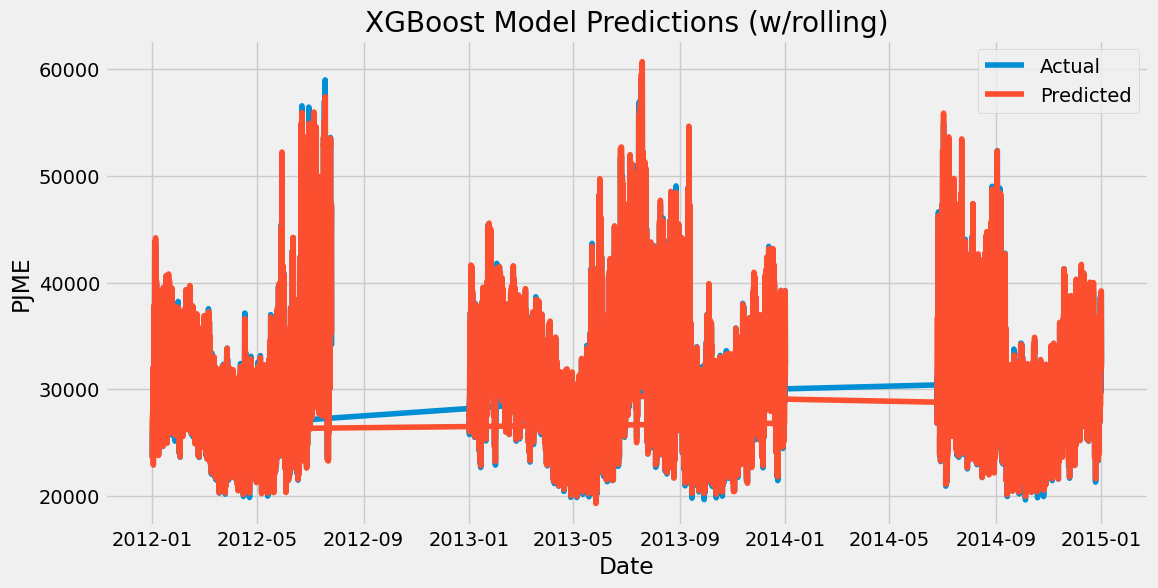

In [ ]:
# Plot the actual values and predicted values for the third model
plt.figure(figsize=(12, 6))
plt.plot(y_test3.index, y_test3.values, label='Actual')
plt.plot(y_test3.index, y_pred3, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions (w/rolling)')
plt.legend()
plt.show()

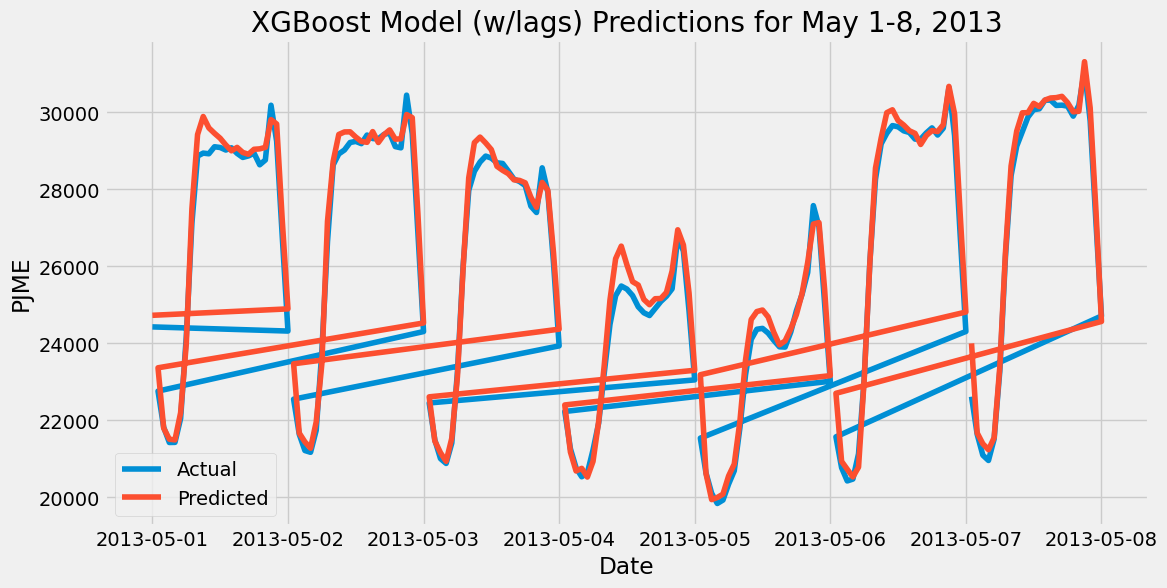

In [ ]:
# Looking at one week of data
# Select the data for one week in May 2013
start_date = '2013-05-01'
end_date = '2013-05-08'
mask = (y_test2.index >= start_date) & (y_test3.index <= end_date)
y_test_week3 = y_test3.loc[mask]
y_pred_week3 = pd.Series(y_pred3, index=y_test3.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week3.index, y_test_week3.values, label='Actual')
plt.plot(y_test_week3.index, y_pred_week3, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model (w/lags) Predictions for May 1-8, 2013')
plt.legend()
plt.show()

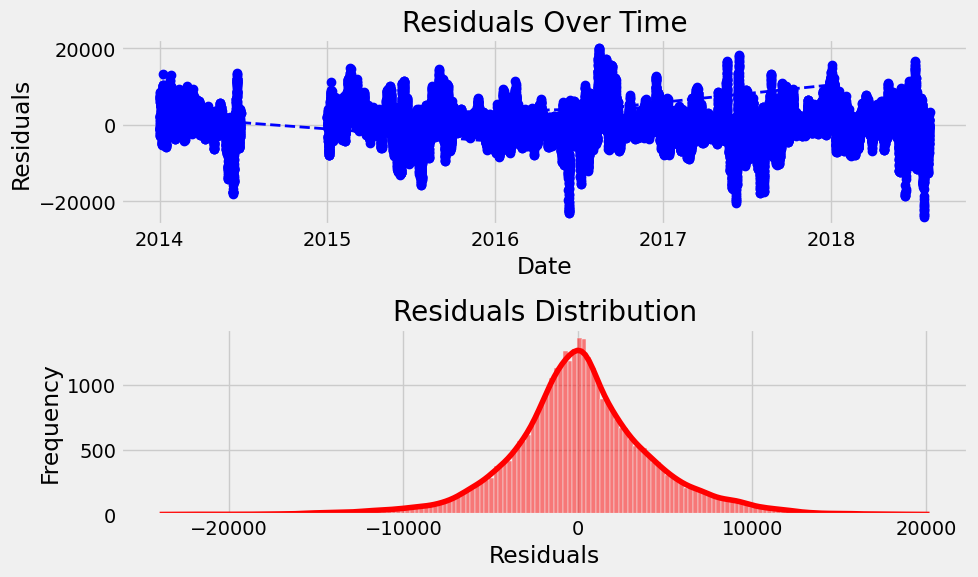

In [ ]:
# Plot residuals
plt.figure(figsize=(10, 6))

# Plot residuals over time
plt.subplot(2, 1, 1)
plt.plot(y_test.index, residuals, color='blue', marker='o', linestyle='dashed', linewidth=2)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot residuals distribution
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, color='red')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
fi_rolling = pd.DataFrame(data=reg3.feature_importances_,
                index =reg3.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

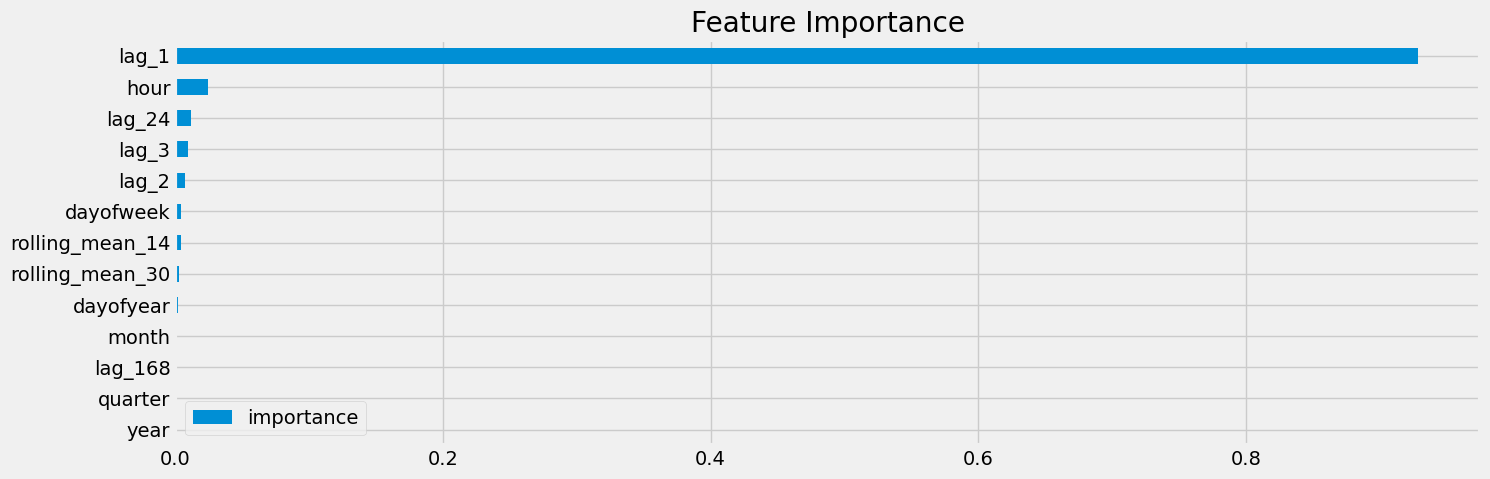

In [ ]:
fi_rolling.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

In [ ]:
#usually Energy demand depends also on holidays, seasonality and weather
import holidays
df_4=df_3.copy()
us_holidays = holidays.US()
df_4['is_holiday'] = df_4.index.to_series().apply(lambda x: int(x in us_holidays))
df_4['is_weekend'] = (df_4.index.dayofweek >= 5).astype(int)
df_4.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,...,weekofyear,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_14,rolling_mean_30,is_holiday,is_weekend
Datetime,,,,,,,,,,,,,,,,,,,,,
1998-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1998-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1998-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1998-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1998-12-31 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
#Regression using holidays

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1', 'lag_2','lag_3', 'lag_24', 'lag_168', 'rolling_mean_14', 'rolling_mean_30', 'is_weekend', 'is_holiday']
TARGET = ['PJME']

# Assuming your data is in a DataFrame called pjm3_df3
X4 = df_4[FEATURES]
y4 = df_4[TARGET]

# Split the data into training and testing sets
X_train_all4, X_test_all4, y_train_all4, y_test_all4 = train_test_split(X4, y4, test_size=0.2, shuffle=False)


# Drop rows with NaN values in either features or target after creating lag features and splitting data
X_train_all4 = X_train_all4.dropna()
y_train_all4 = y_train_all4.dropna()
# Align X_train_all4 and y_train_all4 indices after dropping NaN values
y_train_all4 = y_train_all4.loc[X_train_all4.index]


# Create a TimeSeriesSplit object
tscv4 = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost model
reg4 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index4, test_index4 in tscv.split(X_train_all4):
    X_train4, X_test4 = X_train_all4.iloc[train_index4], X_train_all4.iloc[test_index4]
    y_train4, y_test4 = y_train_all4.iloc[train_index4], y_train_all4.iloc[test_index4]

    reg4.fit(X_train4, y_train4,
        eval_set=[(X_test4, y_test4)], #provide validation set
        verbose=True)

    y_pred_cv4 = reg4.predict(X_test4)
    mse_cv4 = mean_squared_error(y_test4, y_pred_cv4)
    print(f"Mean Squared Error (CV): {mse_cv4}")

    # Calculate the root mean squared error
    rmse4 = np.sqrt(mse_cv4)
    print(f"Root Mean Squared Error: {rmse4}")

    # Calculate the mean absolute error
    mae4 = mean_absolute_error(y_test4, y_pred_cv4)
    print(f"Mean Absolute Error: {mae4}")

# Use the holdout set to assess final performance of the model
y_pred_holdout4 = reg4.predict(X_test_all4)
mse_holdout4 = mean_squared_error(y_test_all4, y_pred_holdout4)
print(f"Holdout Mean Squared Error: {mse_holdout4}")

# Calculate the root mean squared error of the holdout set
rmse_holdout4 = np.sqrt(mse_holdout4)
print(f"Root Mean Squared Error: {rmse_holdout4}")

# Calculate the mean absolute error of the holdout set
mae_holdout4 = mean_absolute_error(y_test_all4, y_pred_holdout4)
print(f"Mean Absolute Error: {mae_holdout4}")


Streaming output truncated to the last 5000 lines.
[18]	validation_0-rmse:1228.60964
[19]	validation_0-rmse:1159.04509
[20]	validation_0-rmse:1096.44500
[21]	validation_0-rmse:1043.85602
[22]	validation_0-rmse:995.69826
[23]	validation_0-rmse:956.39440
[24]	validation_0-rmse:920.84692
[25]	validation_0-rmse:890.31585
[26]	validation_0-rmse:864.31386
[27]	validation_0-rmse:841.19150
[28]	validation_0-rmse:821.17783
[29]	validation_0-rmse:803.24071
[30]	validation_0-rmse:787.96318
[31]	validation_0-rmse:774.53463
[32]	validation_0-rmse:763.67176
[33]	validation_0-rmse:753.05698
[34]	validation_0-rmse:743.95492
[35]	validation_0-rmse:735.08054
[36]	validation_0-rmse:728.76847
[37]	validation_0-rmse:720.74812
[38]	validation_0-rmse:715.42285
[39]	validation_0-rmse:710.10624
[40]	validation_0-rmse:705.43814
[41]	validation_0-rmse:701.68235
[42]	validation_0-rmse:698.00805
[43]	validation_0-rmse:695.61759
[44]	validation_0-rmse:691.29883
[45]	validation_0-rmse:684.92242
[46]	validation_0-rms

In [ ]:
# Make predictions on the test set
y_pred4 = reg4.predict(X_test4)

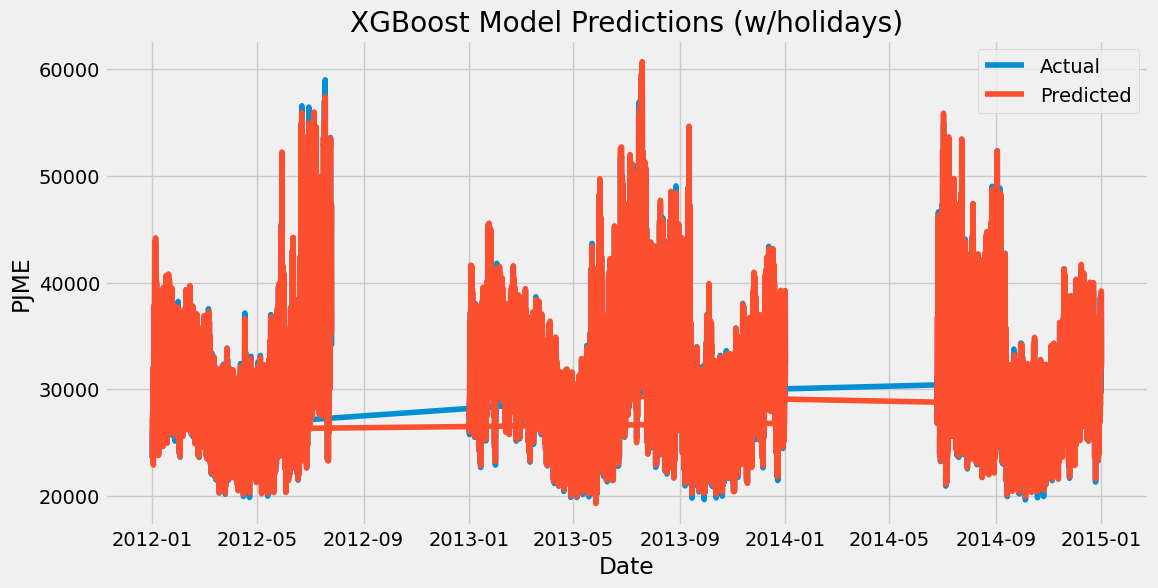

In [ ]:
# Plot the actual values and predicted values for the third model
plt.figure(figsize=(12, 6))
plt.plot(y_test3.index, y_test3.values, label='Actual')
plt.plot(y_test3.index, y_pred3, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions (w/holidays)')
plt.legend()
plt.show()

In [ ]:
fi_holidays = pd.DataFrame(data=reg4.feature_importances_,
                index =reg4.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

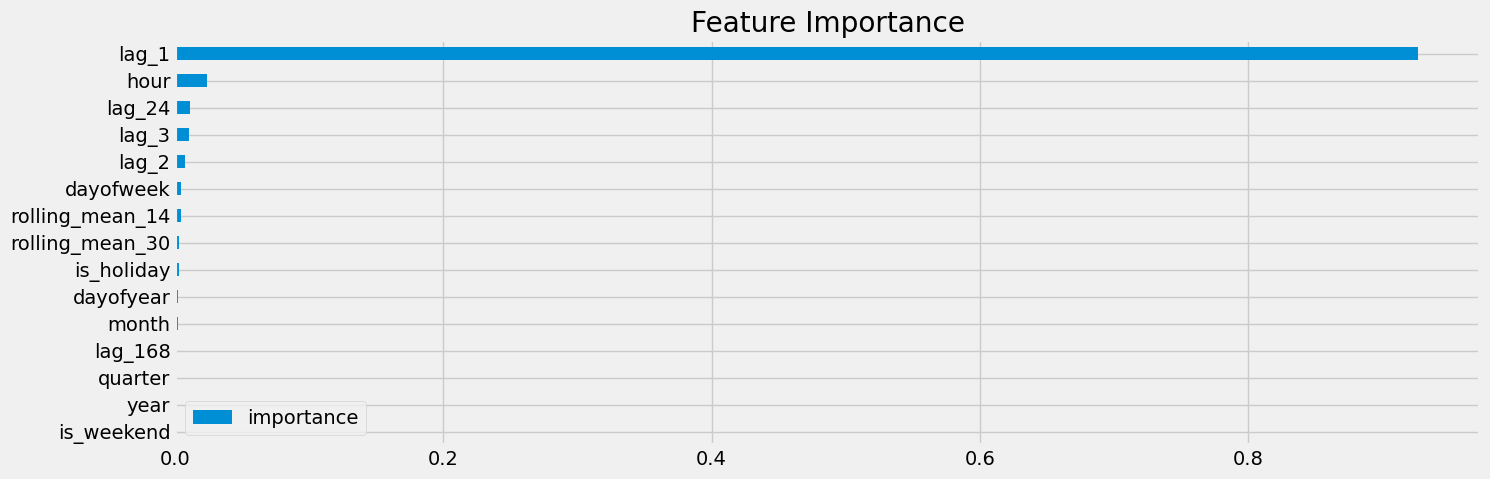

In [ ]:
fi_holidays.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

In [ ]:
#Hyperparameter Tuning for Time Series with XGBoost
#Regression using Lags

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1', 'lag_2','lag_3', 'lag_24', 'lag_168']
TARGET = ['PJME']

# Assuming your data is in a DataFrame called pjm3_df3
X2 = df_2[FEATURES]
y2 = df_2[TARGET]

# Combine X2 and y2 into a single DataFrame
data_combined = pd.concat([X2, y2], axis=1)

# Drop rows with any NaN values
data_combined.dropna(inplace=True)

# Separate the features and target after dropping NaNs
X2_clean = data_combined[FEATURES]
y2_clean = data_combined[TARGET]

# Split the data into training and testing sets
X_train_all2, X_test_all2, y_train_all2, y_test_all2 = train_test_split(
    X2_clean, y2_clean, test_size=0.2, shuffle=False)

# Verify that the lengths match
assert len(X_train_all2) == len(y_train_all2), "Mismatch in training data lengths"
assert len(X_test_all2) == len(y_test_all2), "Mismatch in testing data lengths"

# Create a TimeSeriesSplit object
tscv2 = TimeSeriesSplit(n_splits=5)

# Define parameter grid for random search
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}



# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=reg2,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=tscv2,
    verbose=2,
    scoring='neg_root_mean_squared_error',  # We want to minimize RMSE
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Fit random search to the data
random_search.fit(X_train_all2, y_train_all2.values.ravel())

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}
Best RMSE: 527.9383972048975


In [ ]:
# Predict on test data
y_pred_rs = random_search.best_estimator_.predict(X_test2)

# Calculate evaluation metrics
mse_rs = mean_squared_error(y_test2, y_pred_rs)
rmse_rs = np.sqrt(mse_rs)
mae_rs = mean_absolute_error(y_test2, y_pred_rs)

print(f"Test MSE: {mse_rs}")
print(f"Test RMSE: {rmse_rs}")
print(f"Test MAE: {mae_rs}")

Test MSE: 1621424.5
Test RMSE: 1273.3516796235044
Test MAE: 562.2343139648438


NaNs in target before cleaning: 32896
NaNs in target after cleaning: 0
Training shape: (116268, 30, 1), Test shape: (29068, 30, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 537s 147ms/step - loss: 0.0030 - mean_absolute_error: 0.0370 - val_loss: 3.4699e-04 - val_mean_absolute_error: 0.0120
Epoch 2/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 598s 157ms/step - loss: 5.4331e-04 - mean_absolute_error: 0.0170 - val_loss: 3.1104e-04 - val_mean_absolute_error: 0.0114
Epoch 3/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 538s 148ms/step - loss: 4.2195e-04 - mean_absolute_error: 0.0146 - val_loss: 2.8011e-04 - val_mean_absolute_error: 0.0100
Epoch 4/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 566s 149ms/step - loss: 3.5622e-04 - mean_absolute_error: 0.0131 - val_loss: 2.8978e-04 - val_mean_absolute_error: 0.0110
Epoch 5/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 579s 154ms/step - loss: 3.2164e-04 - mean_absolute_error: 0.0124 - val_loss: 3.5880e-04 - val_mean_absolute_error: 0.0137
Epoch 6/50
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 546s 150ms/step - loss: 3.0311e-04 - mean_absolute_error: 0.0119 - val_loss: 2.4456e-04 - val_mean_absolute_error: 0.0093
Epoch 7/50
3634/3634

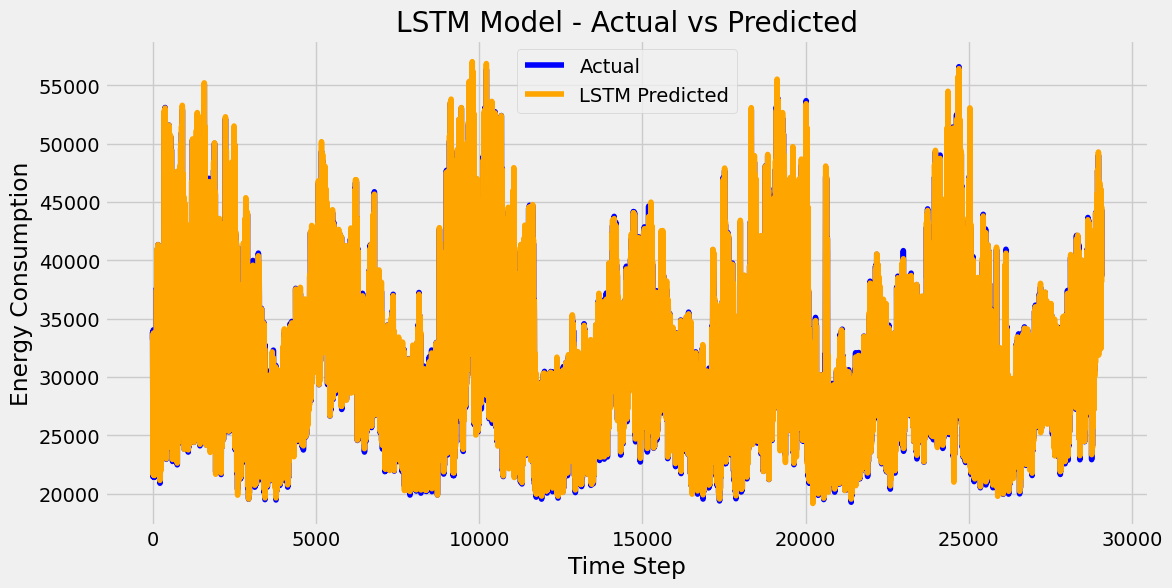

LSTM predictions ready for ensembling!


In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# =========================
# Step 1: Prepare data
# =========================

# Prepare target
target_col = 'PJME'

# ✅ Clean NaNs in target first (common from lag features)
print(f"NaNs in target before cleaning: {df_3[target_col].isna().sum()}")
df_3 = df_3.dropna(subset=[target_col])
print(f"NaNs in target after cleaning: {df_3[target_col].isna().sum()}")

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(df_3[[target_col]])

# Create sequences: past 30 timesteps to predict next
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_target, time_steps)

# Reshape X for LSTM [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/test sets (same as XGBoost split)
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

print(f"Training shape: {X_train_lstm.shape}, Test shape: {X_test_lstm.shape}")

# =========================
# Step 2: Build LSTM model
# =========================

model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# =========================
# Step 3: Train the model
# =========================

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Step 4: Evaluate the model
# =========================

# Predict on test data
y_pred_scaled_lstm = model.predict(X_test_lstm)

# Inverse transform predictions
y_pred_lstm = scaler.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1))
y_test_actual_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Metrics
mse_lstm = mean_squared_error(y_test_actual_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual_lstm, y_pred_lstm)

print(f"LSTM Test MSE: {mse_lstm}")
print(f"LSTM Test RMSE: {rmse_lstm}")
print(f"LSTM Test MAE: {mae_lstm}")

# =========================
# Step 5: Plot predictions
# =========================

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_lstm, label='Actual', color='blue')
plt.plot(y_pred_lstm, label='LSTM Predicted', color='orange')
plt.title('LSTM Model - Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# =========================
# Step 6: Prepare for ensembling
# =========================

# Flatten predictions and actuals for ensembling
y_pred_lstm_final = y_pred_lstm.flatten()
print("LSTM predictions ready for ensembling!")